# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<div class="span5 alert alert-info">
<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for CLT to hold (read CLT carefully), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the CLT, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> Start by computing the margin of error and confidence interval.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What test did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****
</div>

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

<h2>0. Overview of our data.</h2>

It's always helpful to have a look at what we're working with before we start.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


Our data consists of three columns: two are measurements of
body temperature and heart rate, while the third is categorical,
indicating whether the subject is male or female. There are no missing
entries in the data table.

<h2>1. Is the distribution of body temperatures normal?</h2>

There are a few ways to check to see of our data are normally. To start,
we can see if the distribution if unimodal, because if we see multiple
peaks, we know right away to use a different model distribution.

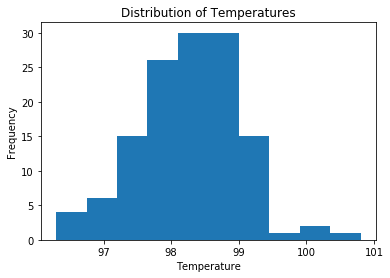

In [3]:
import matplotlib.pyplot as plt

# Plot a histogram of our data to see if we have unimodal distribution.
plt.hist(df.temperature, bins=10)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Distribution of Temperatures')
plt.show()

There may be a tail in our data using this binning, but the histogram 
indicates that a normal distribution may be possible, and we should
further evaluate this.

There are a few ways to check for normality in Python. One approach 
is a built-in function in the <code>scipy</code> package based on
the D'Agostino-Pearson normality test. 


In [4]:
from scipy import stats
stats.normaltest(df.temperature) # Easy, right?

NormaltestResult(statistic=2.7038014333192031, pvalue=0.2587479863488254)

The p-value is roughly 0.26 here, suggesting that the data are normal.

Alternative, we can compare our data to a set of values randomly drawn from a normal
distribution that is centered at the sample mean and has the same variance
as the sample variance, $N(\mu=\bar{x}, \sigma^2=s^2)$.
The Kolmogorov&ndash;Smirnov (KS) test will then be used to compare the original data with this simulated set to verify whether the body temperatures follow a normal distribution.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for N(mu, sigma)
mu = np.mean(df.temperature)
sigma = np.std(df.temperature)
# Random number generation, drawing from N(mu, sigma)
np.random.seed(123)
rand = np.random.normal(mu,sigma, size = df.shape[0])

# Kolmogorov-Smirnov test for normality
stats.ks_2samp(df.temperature, rand) # Make use of the r.v.'s from N(mu, sigma) distribution

Ks_2sampResult(statistic=0.13076923076923075, pvalue=0.20083765666792366)

The p-value is 0.2 in the KS test, which indicates that we can assume the two distributions are the same. A visual example that compares the CDFs of both data sets is included below.

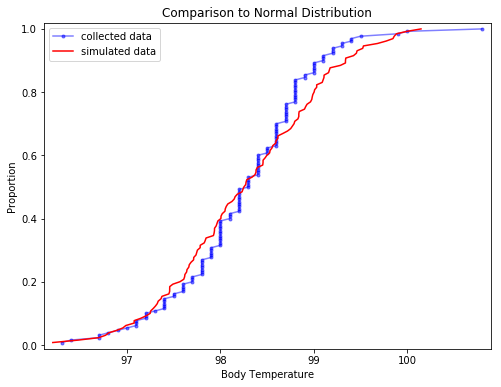

In [6]:
def ecdf(data):
    '''Calculate the x,y-coordinates for CDF of data'''
    x = np.sort(data)
    y = np.arange(1, len(x)+1)/len(x)
    return x,y

x_temp, y_temp = ecdf(df.temperature)
x_rand, y_rand = ecdf(rand)

plt.figure(figsize=(8,6))
_ = plt.plot(x_temp,y_temp, marker='.', linestyle='-', color='blue', alpha=0.5, label='collected data')
_ = plt.plot(x_rand,y_rand, linestyle='-', color='red', label='simulated data')
plt.xlabel('Body Temperature')
plt.ylabel('Proportion')
plt.title('Comparison to Normal Distribution')
plt.margins(0.02)
plt.legend()
plt.show()

Our visual and quantitative comparisons indicate that our data are normally distributed.

<h2> 2. Is the sample size large? Are the observations independent? </h2>

A sample size, <i>n</i>, that is 30 or greater is often considered large enough
to satisfy the Central Limit Theorem. 

In [12]:
n = df.shape[0] # Check sample size
print('There are', str(n), 'samples.')

There are 130 samples.


Our total sample size is 130, so yes, the sample size is large.

We can check for independence in the observations by
performing a simple linear regression on our data, and plotting the residuals.
The residuals should not have any noticeable pattern if the observations are
independent from each other. For instance, for a specific <i>x</i>, there
should be no way to predict the value for the corresponding residual.

An increased heart rate will typically increase body temperature, such as when
a person is exercising, so heart rate will be treated as the independent variable
in our linear regression model.

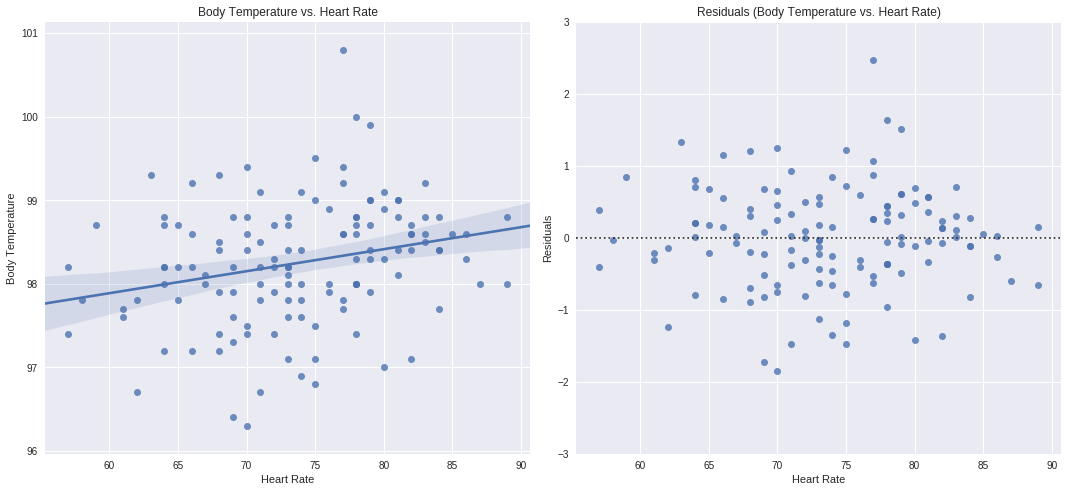

In [8]:
# 2. Check sample size and check for independence
import seaborn as sns
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.regplot('heart_rate', 'temperature', data=df)
plt.xlabel('Heart Rate')
plt.ylabel('Body Temperature')
plt.title('Body Temperature vs. Heart Rate')

plt.subplot(1,2,2)
sns.residplot('heart_rate', 'temperature', data=df)
plt.ylim((-3,3))
plt.xlabel('Heart Rate')
plt.ylabel('Residuals')
plt.title('Residuals (Body Temperature vs. Heart Rate)')
plt.tight_layout()
plt.show()

The residuals for our data are in the right figure, and we see that they are randomly scattered. This tells us that our observations are independent from each other.

<h2>3. Is the true population mean really 98.6 degrees F?</h2>

<b> Would you use a one-sample or two-sample test? Why?</b><br>
It would be appropriate to use a one-sample test here, because there is only one sample mean
that we want to evaluate. Men and women are both part of the general population, so
our data should not be divided according to gender for measuring the mean normal body temperature of a person.
We will use a two-sided test, because it's possible for the 
true body temperature to be greater than or less than the hypothesized value.

H<sub>0</sub>: $\mu$ = 98.6<br>
H<sub>a</sub>: $\mu$ $\neq$ 98.6


<b>In this situation, is it appropriate to use the <i>t</i> or <i>z</i> statistic?</b>

There are two considerations we should make when deciding between <i>t</i>- and <i>z</i>-tests:
(1) what is the sample size and (2) what do we know about population variance?
In general, the <i>t</i>-test works well when sample size is small (n < 30 is the common
rule-of-thumb), and the true population variance is unknown.

Here, we have a large sample size (130 observations), and although we can only compute
the sample variance, this value can be used to estimate the population variance, so the <i>z</i>-test can be used. Determining which Student's 
<i>t</i>-distribution a data set follows depends upon the degrees of freedom,
which is determined by the number of observations (<i>n</i> observations have (<i>n-1</i>) degrees of freedom
in a one-sample test.) As the degrees of freedom increases, the <i>t</i>-distribution
converges more to the normal distribution, justifying the <i>z</i>-test in this case.

In [13]:
mu = 98.6                      # Theoretical mu
xbar = np.mean(df.temperature) # Average from samples
sigma = np.std(df.temperature) # Estimated population variance
n = df.shape[0]

z = (xbar - mu)/(sigma/np.sqrt(n)) # Test statistic for one-sample z-test

# We can compute the p-value either by simulation or
# by looking up the z-score on a table.

from scipy.stats import norm
# We're interested in the probability of finding an observation
# that is more extreme than what we have, so the p-value is
p_value = norm.cdf(z)*2   # Two-tailed test, so need to double
print('z-test statistic:', z)
print('p-value:', p_value)

z-test statistic: -5.47592520208
p-value: 4.35231516588e-08


The <i>p</i>-value here is very small. This indicates that the null hypothesis should be rejected, and that the average body temperature may be different from 98.6$^{\circ}$F.

<b>Now try using the other test. How would the result be different? Why?</b>

In [10]:
mu = 98.6
xbar = np.mean(df.temperature)
s = np.std(df.temperature)
n = df.shape[0]

t = (xbar - mu)/(s/np.sqrt(n))  # Test statistic for one-sample t-test
                                # Note: standard error of the mean is calculated
p_value = stats.t.pdf(t, n-1)*2  # Two-tailed test so need to double it

print('t-test statistic:', t)
print('p-value:', p_value)

t-test statistic: -5.47592520208
p-value: 1.00264080519e-06


Our <i>t</i>-test result is consistent with what we wound with the <i>z</i>-test. The low <i>p</i>-value indicates that the null hypothesis should be rejected.

<h2>4. At what temperature should we consider someone's temperature to be "abnormal"?</h2>

Let's assume we want to be 95% confident in our result. The corresponding critical value, <i>z*</i>, is 1.96. We can use this to compute the margin of error for our sample, and also the corresponding confidence interval. 

In [14]:
# Margin of Error (z-test)
zstar = 1.96
sigma = np.std(df.temperature)
n = df.shape[0]

margin = zstar*(sigma/np.sqrt(n))
print('Margin of Error:', margin)

Margin of Error: 0.125550964803


In [16]:
# Confidence interval (z-test)
mu = np.mean(df.temperature)
CI_lower = mu - margin
CI_upper = mu + margin

print('Confidence Interval (95%):', '['+str(CI_lower) + ','+ str(CI_upper) + ']')

Confidence Interval (95%): [98.1236798044,98.374781734]


From these data, we find that the true mean for normal body temperature is between 98.1 and 98.4 degrees Fahrenheit. Values that fall outside of these boundaries would be considered "abnormal."

<h2>5. Is there a significant difference between males and females in normal temperature?</h2>

<b>What test did you use and why?</b><br>
After dividing our data into groups according to gender, we have 65 observations in each group.
This is still a large sample, so a <i>z</i>-test would still be appropriate. We want to see how normal body temperature may be different for males and females, so there are two means we'd like to compare and we will need a two-sample test to do so.

H<sub>0</sub>: $\mu_M$ = $\mu_F$<br>
H<sub>a</sub>: $\mu_M$ $\neq$ $\mu_F$


An easier way to set up our hypotheses:<br>
H<sub>0</sub>: $\mu_M$ - $\mu_F$ = 0<br>
H<sub>a</sub>: $\mu_M$ - $\mu_F$ $\neq$ 0


In [18]:
males = df[df['gender'] == 'M']
females = df[df['gender'] == 'F']

n_males = males.shape[0] # Sample sizes
n_females = females.shape[0]

xbar_m = np.mean(males.temperature) # Sample means
xbar_f = np.mean(females.temperature)

var_m = np.var(males.temperature) # Variances
var_f = np.var(females.temperature)

SE = np.sqrt(var_m/n_males + var_f/n_females) # Standard error for both groups

z = (xbar_m - xbar_f)/SE # Test statistic for two-sample z-test
p_value = norm.cdf(z)*2   # Two-tailed test, so need to double
print('sample means (male, female):', xbar_m, xbar_f)
print('z-test statistics (two-sample test)', z)
print('p-value:', p_value)

sample means (male, female): 98.1046153846154 98.39384615384613
z-test statistics (two-sample test) -2.30322028919
p-value: 0.0212664518301


Here, the two-sample <i>z</i>-test has a <i>p</i>-value of 0.021, which is a rather low probability. We can say that there is strong evidence against the null hypothesis, suggesting that the normal body temperatures may be different in men and women.

<b>Write a story with your conclusion in the context of the original problem.</b>

The normal body temperature in humans is often considered to be 98.6 degrees Fahrenheit, but our findings from these data indicate that it may actually be much lower. Back in 1868, Carl Wunderlich reportedly measured body temperatures from the armpit for many different subjects, multiple times. These measurements may not be the best representation of body temperature, however, and body temperatures are known to vary when measured from different body parts. 

It is unclear where the data provided for this exercise came from, so it is possible that the average body temperature has discrepancies due to different measurement locations. Oral measurements under the tongue are usually higher than those taken from the armpit, for example.
Even if these measurements were taken consistently in the armpit to match Wunderlich's study, body temperatures can still fluctuate naturally throughout the day. Furthermore, the health status and age for a person can affect their normal average body temperature, which can help explain why our sample means are lower than 98.6.

The differences in the average normal body temperatures for male and female subjects is perhaps less surprising. Men and women have natural biological distinctions that affect body temperature, such as in resting metabolic rates. The prescence of different hormones and their concentration levels can also contribute to temperature differences. Normal body temperature is often higher for women during ovulation, for example, to allow for proper function in the reproductive cycle.